# Natural Computing

## Exercises on Evolutionary Computation

In [1]:
import tsplib95 # pip install tsplib95
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from operator import itemgetter
import time
%matplotlib inline

### Exercise 6

#### Simple EA for TSP:
- Random initialization of the population
- Binary tournament selection (results in mating pool)
- Generational gap replacement strategy (10% elitism: 10% of worst offspring replaced by best current parents)
- Fixed size population

### Utility functions

In [14]:
# List of tuples representing edges for plotting
def get_edge_list(tour):
    edge_list = []
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        edge_list.append( (a, b) )
    # close tour
    edge_list.append( (tour[-1], tour[0]) )
    return edge_list

# Plot tour including performance
def plot_tour(tour, distance, problem):
    edge_list = get_edge_list(tour)
    nx.draw_networkx(problem.get_graph(), 
                     pos=problem.node_coords, 
                     edgelist=edge_list, 
                     node_size=50,
                     with_labels=False
                    )
    plt.title(f"{problem.name} ({distance})")
    plt.show()

In [4]:
# Get best and worst tour, and average tour distance in population
def population_stats(population):
    best = min(population, key=itemgetter(1))
    worst = max(population, key=itemgetter(1))
    avg = np.mean([tour[1] for tour in population])
    return best, worst, avg

# Summary of a population
def track_progress(population, gen_id):
    # get population statistics
    best, worst, avg = population_stats(population)
    # print statistics
    print('='*5, f"Generation {gen_id}", '='*5)
    print("Best: ", best[1])
    print("Worst: ", worst[1])
    print("Average: ", avg)
    # plot the best tour
    plot_tour(best[0], best[1], problem)

In [28]:
def plot_history(generations):
    best_scores = [best[1] for best, _, _ in generations]
    worst_scores = [worst[1] for _, worst, _ in generations]
    avg_scores = [avg for _, _, avg in generations]
    
    x_range = range(len(generations))
    plt.figure(figsize=(12, 8))
    plt.plot(x_range, best_scores, label = "best distance")
    plt.plot(x_range, worst_scores, label = "worst distance")
    plt.plot(x_range, avg_scores, label = "avg distance")
    plt.plot(x_range, [solution_dist]*nr_of_generations, label = "optimal distance")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.title("Evolution over generations", size=14)
    plt.legend()
    plt.show()

### Evolutionary Algorithm

In [ ]:
def init_population(problem, size):
    nodes = list(problem.get_nodes())
    population = [np.random.permutation(nodes) for _ in range(size)]
    population = [(list(tour), total_distance(tour, problem)) for tour in population] # tuple(tour, distance)
    return population

In [3]:
# Fitness function
def total_distance(tour, problem):
    total_dist = 0
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        dist = problem.wfunc(a, b)
        total_dist += dist
    # close tour
    total_dist += problem.wfunc(tour[-1], tour[0])
    return total_dist

In [5]:
# Binary tournament selection
def tournament(population):
    participants = random.sample(population, 2)
    winner = min(participants, key=itemgetter(1))
    return winner

In [6]:
def ordered_crossover(parent1, parent2):
    # choose two cut points
    length = len(parent1)
    pos1, pos2 = random.sample(range(length), 2)
    start_pos = min(pos1, pos2)
    end_pos = max(pos1, pos2)
    
    # slice between cut points
    child1 = parent1[start_pos:end_pos+1]
    child2 = parent2[start_pos:end_pos+1]
    
    # fill missing cities in order they appear in other parent
    missing_cities1 = [city for city in parent2 if city not in child1]
    missing_cities2 = [city for city in parent1 if city not in child2]
    
    # append missing cities starting from 2nd cut point
    child1 += missing_cities1
    child2 += missing_cities2
    return child1, child2

def mutation(tour):
    # shallow copy of original
    mutated_tour = tour[:]
    
    # choose two positions
    length = len(tour)
    pos1, pos2 = random.sample(range(length), 2)
    
    # reverse sequence mutation
    mutated_tour[pos1], mutated_tour[pos2] = mutated_tour[pos2], mutated_tour[pos1]
    return mutated_tour

In [7]:
def next_generation(mating_pool, size, p_c, p_m):
    new_population = []
    while len(new_population) < size:
        # select two parents from mating pool
        parent1, parent2 = random.sample(mating_pool, 2) 
        parent1, parent2 = parent1[0], parent2[0] # get tour            
        # initalize offspring to be equal to parent
        child1, child2 = parent1[:], parent2[:]

        # ordered crossover
        test_p_c = np.random.uniform()
        if test_p_c < p_c:
            child1, child2 = ordered_crossover(parent1, parent2)
                
        # mutation
        test_p_m = np.random.uniform()
        if test_p_m < p_m:
            child1, child2 = mutation(child1), mutation(child2)
            
        # add offspring to new population
        dist1 = total_distance(child1, problem)
        dist2 = total_distance(child2, problem)
        new_population += [ (child1, dist1), (child2, dist2) ]
    return new_population

In [8]:
def exert_elitism(population, new_population, size, elitism):
    # compute elite size
    elite = int(size * elitism)
    
    # drop worst tours from new population
    distances_new = [distance for _, distance in new_population]
    idx_drop = list(np.argpartition(distances_new, -elite))[-elite:]
    elite_population = [tour for i, tour in enumerate(new_population) if i not in idx_drop]
        
    # add elite (best tours) from current population to new population
    distances_old = [distance for _, distance in population]
    idx_elite = list(np.argpartition(distances_old, elite))[:elite]  
    elitists = [tour for i, tour in enumerate(population) if i in idx_elite]
    elite_population += elitists
    
    return elite_population

In [9]:
def EA_TSP(problem, size=100, nr_of_generations=200, p_c=0.9, p_m=0.2, elitism=0.1, plot_every=-1):
    # history
    generations = []
    
    # initialize population
    population = init_population(problem, size)
    track_progress(population, 1)
    
    for t in range(nr_of_generations):
        # tournament selection for mating pool
        mating_pool = [tournament(population) for _ in range(size)]
        
        # generate offspring for generational replacement
        new_population = next_generation(mating_pool, size, p_c, p_m) 
        
        # elitism
        new_population = exert_elitism(population, new_population, size, elitism)    
        population = new_population
        
        generations.append(population_stats(population))
        
        # plot every so often to monitor progress
        if t % plot_every == plot_every-1:
            track_progress(new_population, t+1)
        
    return generations

### TSP: Berlin52

In [10]:
tsp_problem_path = 'data/berlin52.tsp'
tsp_solution_path = 'data/berlin52.opt.tour'

In [11]:
# TSP problem information
problem = tsplib95.load_problem(tsp_problem_path)
print("--- TSP problem information ---")
print("Name: ", problem.name)
print("Comment: ", problem.comment)
print("Dimension: ", problem.dimension)
print("Edge weight type: ", problem.edge_weight_type)

--- TSP problem information ---
Name:  berlin52
Comment:  52 locations in Berlin (Groetschel)
Dimension:  52
Edge weight type:  EUC_2D


Optimal solution:  7542


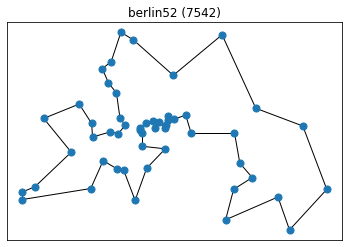

In [15]:
# Visualize TSP and show optimal solution
solution = tsplib95.load_solution(tsp_solution_path)
solution_dist = problem.trace_tours(solution)[0]
print("Optimal solution: ", solution_dist)
plot_tour(solution.tours[0], solution_dist, problem)

===== Generation 1 =====
Best:  26807
Worst:  33625
Average:  29887.66


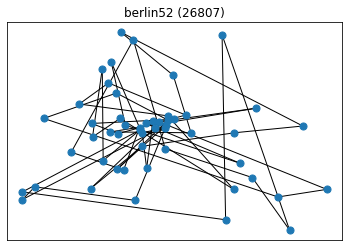

===== Generation 200 =====
Best:  10478
Worst:  13663
Average:  11889.32


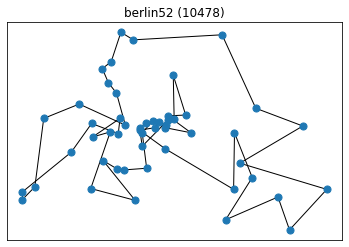

===== Generation 400 =====
Best:  8547
Worst:  12639
Average:  10093.11


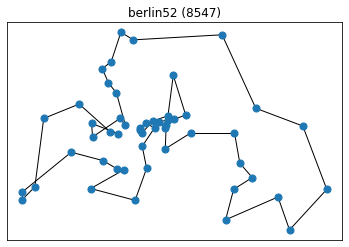

===== Generation 600 =====
Best:  8313
Worst:  12377
Average:  10179.03


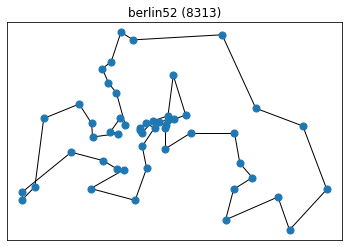

===== Generation 800 =====
Best:  7877
Worst:  11558
Average:  9095.91


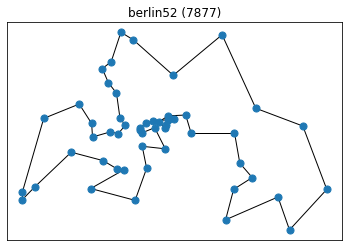

===== Generation 1000 =====
Best:  7737
Worst:  11857
Average:  9507.1


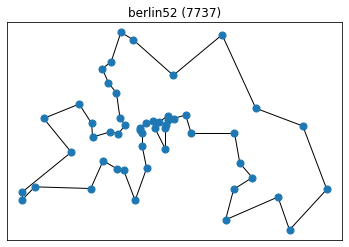

Elapsed time: 16.78s


In [16]:
nr_of_generations = 1000
plot_every = nr_of_generations / 5

start = time.time()
generations = EA_TSP(problem, 
                     nr_of_generations=nr_of_generations, 
                     plot_every=plot_every)
end = time.time()
print("Elapsed time: {0:0.2f}s".format(end-start))

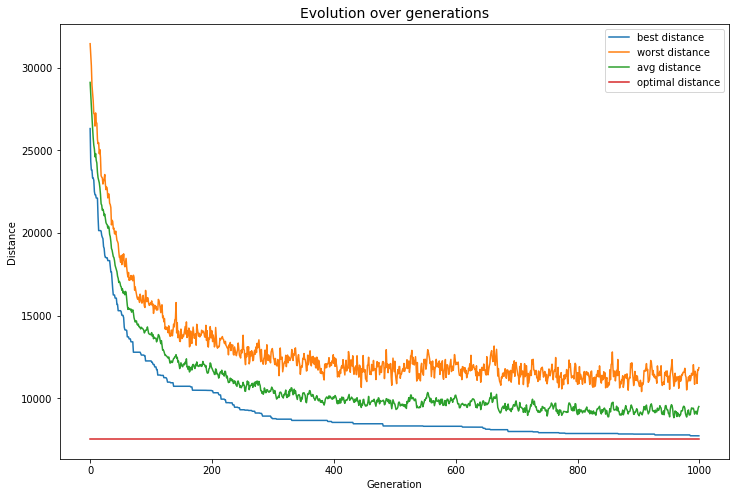

In [29]:
# Plot population statistics over generations
plot_history(generations)